In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import glob, os    
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
import addfips
plotly.tools.set_credentials_file(username='tpjoe33', api_key='rc1Ncjms567YGfGS9VlU')

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [50]:
# importing data
part_d_exp_df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('Data/cms_medicare_test/', \
                                                              "part_d_prescriber_2014000000000000.csv"))))
exclusion_df = pd.read_csv('Data/Exclusion_list.csv', low_memory=False)

part_d_exp_df = part_d_exp_df[['npi', 'nppes_provider_city','nppes_provider_state', 'specialty_description', 'description_flag',\
                        'drug_name', 'generic_name', 'bene_count', 'total_claim_count','total_day_supply', \
                        'total_drug_cost', 'bene_count_ge65', 'total_claim_count_ge65', 'total_day_supply_ge65',\
                        'total_drug_cost_ge65']]

# assigning exclusion (False = 0, True = 1)
exclusion_npi = exclusion_df['NPI'][exclusion_df['NPI'] != 0].values.tolist()
part_d_exp_df['is_excluded'] = 0
num_excluded = len(part_d_exp_df.loc[part_d_exp_df['npi'].isin(exclusion_npi)])
part_d_exp_df.loc[part_d_exp_df['npi'].isin(exclusion_npi), 'is_excluded'] = 1

# separating dataset for training models and for data exploration
part_d_df = part_d_exp_df[['npi', 'nppes_provider_city', 'nppes_provider_state', 'specialty_description', \
                      'drug_name', 'total_claim_count', 'total_day_supply', 'total_drug_cost', 'is_excluded']]
part_d_exp_df = part_d_exp_df[part_d_df['nppes_provider_state'].isin(states)]

print("The data has a size of {}".format(part_d_df.shape))

The data has a size of (2413136, 9)


# Medicare Data Exploration

In [3]:
tqdm.pandas()
county_ref = pd.read_csv('Data/uscitiesv1.4.csv')
county_ref['city'] = county_ref['city'].apply(str.upper)
def get_fip(city, state):
    #if all(x in county_ref[['city', 'state']].values for x in [city, state]):
    try:
        county = county_ref[(county_ref['city'] == city.upper()) &\
                            (county_ref['state_id'] == state.upper())]['county_fips'].values[0]
    except IndexError:
        county = None
    return county
        
#part_d_exp_df['county'] = part_d_exp_df.progress_apply(lambda x: find_county(x['nppes_provider_city'], \
#                                                                    x['nppes_provider_state']), axis=1)

In [4]:
# Dataprocessing
part_d_exp_df['cost_per_bene'] = part_d_exp_df['total_drug_cost']/part_d_exp_df['bene_count']
part_d_df_city_mean = part_d_exp_df.groupby(['nppes_provider_state', 'nppes_provider_city']).mean()
part_d_df_city_mean = part_d_df_city_mean.reset_index()
part_d_df_city_mean['fip'] = part_d_df_city_mean.apply(lambda x: get_fip(x['nppes_provider_city'], \
                                                                         x['nppes_provider_state']), axis=1)

part_d_df_state_sum = part_d_exp_df.groupby(['nppes_provider_state']).sum()
part_d_df_state_sum = part_d_df_state_sum.reset_index()

In [5]:
part_d_exp_df.head()

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,cost_per_bene
0,1205995735,GRAND RAPIDS,MI,Psychiatry,S,RISPERIDONE,RISPERIDONE,34.0,448,12858,5699.76,NaN,47.0,1328.0,514.74,0,167.640000
1,1073887618,NEW KENSINGTON,PA,Nurse Practitioner,S,METOPROLOL TARTRATE,METOPROLOL TARTRATE,16.0,73,3307,501.37,NaN,62.0,2797.0,443.34,0,31.335625
2,1114960846,CHESTER,VA,Internal Medicine,S,GABAPENTIN,GABAPENTIN,30.0,166,5794,3628.69,NaN,139.0,4804.0,2963.24,0,120.956333
3,1801991666,GREAT NECK,NY,Internal Medicine,S,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE,15.0,87,2610,646.41,15.0,87.0,2610.0,646.41,0,43.094000
4,1811907694,MARSHFIELD,WI,Internal Medicine,S,LEVOTHYROXINE SODIUM,LEVOTHYROXINE SODIUM,27.0,124,8261,2708.21,NaN,94.0,7248.0,2270.92,0,100.304074


In [6]:
# Finding top selling drugs
top_drug_price = part_d_exp_df.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_drug_count = part_d_exp_df.groupby('drug_name').count().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_drug_price.head(10)

,npi,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,cost_per_bene
drug_name,,,,,,,,,,,
SOVALDI,334919957399,1744.0,8947,249392,2.532243e+08,373.0,2285.0,63224.0,6.431152e+07,0,6.164863e+06
NEXIUM,20643133237590,96911.0,693992,28212624,2.413137e+08,18694.0,362646.0,14733077.0,1.242874e+08,22,7.431418e+06
CRESTOR,22195583799450,142719.0,861895,40808969,2.410965e+08,33982.0,497310.0,23455272.0,1.382428e+08,13,7.821321e+06
ABILIFY,7685299452402,27644.0,256894,7317136,2.143192e+08,1748.0,66052.0,1653967.0,4.558757e+07,17,5.803229e+06
ADVAIR DISKUS,19394148475384,92656.0,550078,20822146,2.053751e+08,19869.0,277713.0,10639781.0,1.040722e+08,22,6.215206e+06
SPIRIVA,17627033220212,78401.0,529699,20333899,1.943659e+08,18825.0,290781.0,11269220.0,1.075553e+08,20,5.211132e+06
LANTUS SOLOSTAR,14747544327646,58863.0,391425,16973288,1.772395e+08,11568.0,187527.0,8367729.0,8.277701e+07,17,5.049731e+06
JANUVIA,14347810129652,42482.0,407903,16318909,1.584337e+08,8702.0,239966.0,9517328.0,9.231197e+07,22,4.441434e+06
REVLIMID,729743473436,846.0,16026,421666,1.502614e+08,361.0,10735.0,283501.0,1.002989e+08,0,1.826141e+06


In [10]:
trace_price = go.Bar(x=top_drug_price.index, y=top_drug_price['total_drug_cost'], name='by price', 
                     marker=dict(color='rgb(241,250,248)', line=dict(color='rgb(000,000,102)', width=1.5)),
                     opacity = 0.8)
                     
trace_count = go.Bar(x=top_drug_count.index, y=top_drug_count['total_drug_cost'], name='by amount', 
                     marker=dict(color='rgb(241,250,248)', line=dict(color='rgb(13,129,106)', width=1.5)),
                     opacity = 0.8)
data = [trace_price, trace_count]

updatemenus = list([
    dict(
        buttons=list([
            dict(label = 'by price',
                method = 'update',
                args = [{'visible': [True, False]},
                         {'title': 'Top 10 Drugs in Medicare (By Price)'}]),
            dict(label = 'by amount',
                method = 'update',
                args = [{'visible': [False, True]},
                        {'title': 'Top 10 Drugs in Medicare (By Amount)'}])
        ]),
        direction = 'down',
        pad = {'r': 10, 't': 10},
        showactive = True,
        x = .8,
        xanchor = 'left',
        y = 1.1,
        yanchor = 'top' )
    
])
layout = dict(title='Top 10 Drugs in Medicare (By Price)', showlegend=False, 
              margin=go.Margin(l=50, r=100, b=120, t=10, pad=4),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='drug_dropdown')

In [9]:
trace1 = go.Box(
    y=part_d_df_state_sum.bene_count_ge65/part_d_df_state_sum.bene_count*100,
    name = 'By No. of Beneficiaries',
    boxpoints='all',
    jitter=0.3,
    marker = dict(
        color = 'rgb(102,204,255)'
    ),
    boxmean=True
)

trace2 = go.Box(
    y=part_d_df_state_sum.total_claim_count_ge65/part_d_df_state_sum.total_claim_count*100,
    name = 'By No. of Claims',
    boxpoints='all',
    jitter=0.3,
    boxmean=True,
    marker = dict(
        color = 'rgb(051,153,255)'
    )
)

trace3 = go.Box(
    y=part_d_df_state_sum.total_drug_cost_ge65/part_d_df_state_sum.total_drug_cost*100,
    name = 'By Cost of Claims',
    boxpoints='all',
    jitter=0.3,
    boxmean=True,
    marker = dict(
        color='rgb(000,051,153)'
    )
)


layout = go.Layout(
    title='Medicare Precsription Used by Beneficiaries of 65+ Age',
    width=500,
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        autotick=True,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        title='Percentages (%)',
        zeroline=False
    ),
    legend=dict(
        orientation='h'
    ),
)

data = [trace1, trace2, trace3]
fig= go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='alcohol-box-plot')

In [8]:
part_d_df_city_mean_plt = part_d_df_city_mean[['fip', 'cost_per_bene']].dropna().groupby('fip').mean()

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(1, part_d_df_city_mean_plt.describe(percentiles=[.90]).values[5], len(colorscale) - 1))

fips = part_d_df_city_mean_plt.index.tolist()
values = part_d_df_city_mean_plt['cost_per_bene'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=3.2, title='Average Medicare Prescription Cost in the USA',
    legend_title='Average Cost per Beneficiary'
)
#py.iplot(fig, filename='choropleth_medicare_cost')

## Exploring Excluded Providers

In [7]:
# Top 10 drugs sold by excluded providers
excluded_providers = part_d_exp_df.loc[part_d_exp_df['is_excluded'] == 1]
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]

# Plotting
trace_ex_price = go.Bar(x=excluded_drug_rank.index, y=excluded_drug_rank['total_drug_cost'], name='by price', 
                     marker=dict(color='rgb(255,204,204)', line=dict(color='rgb(204,000,000)', width=1.5)),
                     opacity = 0.8)  
data = [trace_ex_price]
layout = dict(title='Top 10 Drugs in Medicare Sold by Excluded Providers (By Price)', showlegend=False, 
              margin=go.Margin(l=50, r=100, b=120, t=50, pad=4))

fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='drug_excluded')

In [11]:
# Assigning narcotics/opioid (False = 0, True = 1)
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False)
common_narcotics = ['OXYCONTIN', 'OXYMORPHONE HCL ER', 'MORPHINE SULFATE ER', 'OXYCODONE HCL', 'OXYCODONE-ACETAMINOPHEN', \
                    'FENTORA', 'SUBSYS', 'HYDROCODONE-ACETAMINOPHEN', 'SUBOXONE', 'OPANA ER', 'HYDROCODONE-ACETAMINOPHEN']
part_d_exp_df['is_narcotics'] = 0
part_d_exp_df.loc[part_d_df['drug_name'].isin(common_narcotics), 'is_narcotics'] = 1

In [12]:
# Exploring behavior of excluded providers
behavior = part_d_exp_df[['total_claim_count', 'total_drug_cost', 'total_day_supply', \
               'is_excluded', 'is_narcotics']].groupby(['is_excluded', 'is_narcotics']).mean()
behavior

total_claim_count  total_drug_cost  total_day_supply
is_excluded is_narcotics                                                      
0           0                     49.894652      3889.242973       2042.019014
            1                     72.191577      4013.876055       1541.143612
1           0                     54.852388      3531.065271       1901.256151
            1                    200.796748     41208.777398       5495.056911

In [13]:
data = [{'x': ['Non-excluded Providers', 'Non-excluded Providers ', \
            'Excluded Providers', 'Excluded Providers '],
        'y': behavior['total_drug_cost'].values.tolist(),
        'text': ['Average total amount per beneficiary: {0:.0f}'.format(i) 
                 for i in behavior['total_claim_count'].values.tolist()],
        'mode': 'markers',
        'marker': {
            'color': ['rgb(051,153,255)', 'rgb(255,102,102)', 'rgb(000,051,153)', 'rgb(204,000,000)'],
            'size': behavior['total_claim_count'].values.tolist(),
            'showscale': False
        }
    }
]

annotations=[dict(x='Non-excluded Providers', y=10000, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Non-excluded Providers ', y=12500, xref='x', yref='y', text='Narcotics', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers', y=10500, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers ', y=68000, xref='x', yref='y', text='Narcotics',\
                  showarrow=True, arrowhead=7, ax=0, ay=-40)]

layout = dict(title='Medicare Prescription Cost and Amount by Excluded and Non-excluded Providers', showlegend=False, 
              annotations=annotations, margin=go.Margin(l=50, r=100, b=120, t=50, pad=4), 
              yaxis=dict(title='Average Cost Per Beneficiary ($)'))

fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='provider-behavior')

In [135]:
# Creating fraction of top 5 specialties from non-excluded and excluded providers
nonexcluded_providers = part_d_exp_df[part_d_exp_df['is_excluded'] == 0]
nonexcluded_providers_specialty = nonexcluded_providers.groupby\
('specialty_description').count().sort_values('npi', ascending=False).head()/len(nonexcluded_providers)*100
nonexcluded_providers_specialty = nonexcluded_providers_specialty['npi'].to_dict()

excluded_providers_specialty = excluded_providers.groupby \
('specialty_description').count().sort_values('npi', ascending=False).head()/len(excluded_providers)*100
excluded_providers_specialty = excluded_providers_specialty['npi'].to_dict()

for i, j in zip(list(nonexcluded_providers_specialty.keys()), list(excluded_providers_specialty.keys())):
    if i not in excluded_providers_specialty.keys():
        excluded_providers_specialty.update({i: 0})
    if j not in nonexcluded_providers_specialty.keys():
        nonexcluded_providers_specialty.update({j: 0})

nonex_ex_specialty = pd.DataFrame(0, index=excluded_providers_specialty.keys(), columns=['nonexcluded', 'excluded'])
nonex_ex_specialty.loc[:, 'nonexcluded'] = pd.Series(nonexcluded_providers_specialty)
nonex_ex_specialty.loc[:, 'excluded'] = pd.Series(excluded_providers_specialty)
nonex_ex_specialty.loc['Others'] = list(100 - nonex_ex_specialty.sum().values)
nonex_ex_specialty

,nonexcluded,excluded
Internal Medicine,28.505841,35.997764
Family Practice,29.878419,27.249860
General Practice,0.000000,6.847401
Psychiatry,0.000000,5.449972
Nurse Practitioner,8.728942,4.387926
Physician Assistant,4.725027,0.000000
Cardiology,4.088722,0.000000
Others,24.073049,20.067077


In [138]:
trace_dict = {}
color = ["#08306b", "#08519c", "#1361a9", "#2171b5", "#4292c6", "#6baed6", "#9ecae1", "#c6dbef"]
for i, specialty in enumerate(nonex_ex_specialty.index):
    trace_dict.update({'trace' + specialty: go.Bar(x=['Non-excluded Providers', 'Excluded Providers'], 
                                     y=nonex_ex_specialty.loc[specialty].values.tolist(),
                                     name=specialty, marker=dict(color=color[i]))})

data = [trace_dict[trace] for trace in trace_dict]

layout = go.Layout(barmode='stack', yaxis=dict(title='Percentages of Provider Specialty (%)'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# Models

In [2]:
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

## Classification of Drug Proviers

In [146]:
# Creating grouped drug data frame and grouped provider datafrmae
drug_list = sorted(part_d_df['drug_name'][part_d_df['is_excluded']==1].unique())
npi_group = part_d_df.groupby('npi').sum()
npi_drug_group_df = part_d_df.groupby(['drug_name', 'npi']).sum()

In [148]:
print("There are {} unique providers".format(len(npi_group)))
print("There are {} unique drugs, of which {} are sold by excluded provider for at least once." \
      .format(len(npi_drug_group_df), len(drug_list)))

There are 487241 unique providers
There are 2412087 unique drugs, of which 553 are sold by excluded provider for at least once.


In [149]:
# Creating feature tables for input (row=providers, columns=cost fraction of drugs each provider sold)
npi_drug_df = pd.DataFrame(0, index=npi_group.index, columns=drug_list)
for drug in tqdm(drug_list):
    npi_drug_df.loc[npi_drug_group_df.loc[drug][['total_drug_cost']].index, [drug]] = \
    npi_drug_group_df.loc[drug][['total_drug_cost']].values/ \
    npi_group.loc[npi_drug_group_df.loc[drug][['total_drug_cost']].index, ['total_drug_cost']].values
npi_drug_df.head()

100%|██████████| 553/553 [11:31<00:00,  1.25s/it]


In [153]:
# Check nulls
print(npi_drug_df.isnull().sum().sum())
npi_drug_df = npi_drug_df.dropna(axis = 0)
print(npi_drug_df.isnull().sum().sum())
print(npi_drug_df.shape)

0
(487241, 553)


In [3]:
# Saving
npi_drug_df.to_pickle('npi_drug_df.pickle')
npi_group.to_pickle('npi_group.pickle')

NameError: name 'npi_drug_df' is not defined

In [3]:
# Loading
npi_drug_df = pd.read_pickle('npi_drug_df.pickle')
npi_group = pd.read_pickle('npi_group.pickle')

### Applying PCA

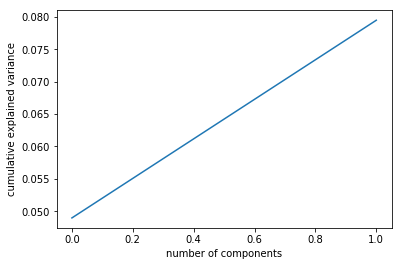

In [4]:
pca = decomposition.PCA(n_components=2)
pca.fit(npi_drug_df)
npi_drug_df_transformed = pca.transform(npi_drug_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [5]:
npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
df = pd.concat([pd.DataFrame(npi_drug_df_transformed, index=npi_label.index), npi_label], axis=1)

In [6]:
npi_label['is_excluded'].value_counts()

0    486675
1       566
Name: is_excluded, dtype: int64

### Training without down/upsampling

In [164]:
X = df.drop(['is_excluded'], axis=1)
y = df['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [165]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.990863146003


array([[326078,      0],
       [   116,    257]])

In [167]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.453074572367


array([[160596,      1],
       [   193,      0]])

The model was unable to capture the minor class.

### With upsampling/downsampling

In [179]:
# Upsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
df_upsampled['is_excluded'].value_counts()

0    486675
1      5480
Name: is_excluded, dtype: int64

In [172]:
X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [173]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.989502948024


array([[326054,      3],
       [   757,   2929]])

In [174]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.985578214945


array([[160586,     32],
       [   415,   1379]])

In [202]:
# Downsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=48670, random_state=42) # Reduce by 10 times
df_downsampled = pd.concat([df_majority_downsampled, df_minority]) 
df_downsampled['is_excluded'].value_counts()

0    48670
1      566
Name: is_excluded, dtype: int64

In [203]:
X = df_downsampled.drop(['is_excluded'], axis=1)
y = df_downsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [204]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.985320078056


array([[32608,     0],
       [   93,   287]])

In [205]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.479441391757


array([[16055,     7],
       [  185,     1]])

In [206]:
# Downsampling+Upsampling
df_updownsampled = pd.concat([df_majority_downsampled, df_minority_upsampled]) 
df_updownsampled['is_excluded'].value_counts()

0    48670
1     5480
Name: is_excluded, dtype: int64

In [207]:
X = df_updownsampled.drop(['is_excluded'], axis=1)
y = df_updownsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [208]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.987980670013


array([[32553,    76],
       [  635,  3016]])

In [209]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.982517938842


array([[15924,   117],
       [  314,  1515]])

### Classification Models Comparison

In [7]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc

seed = 42

In [8]:
# Upsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
df_upsampled['is_excluded'].value_counts()

0    486675
1      5480
Name: is_excluded, dtype: int64

In [11]:
# Identifying the best model algorithm
colors = ["#08306b", "#08519c", "#1361a9", "#4292c6", "#6baed6", 'rgb(76,000,153)', 'rgb(153,000,153)']

X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'}

names = ["RBF SVM", "Nearest Neighbors", "Naive Bayes",
         "GradientBoost", "AdaBoost", 
         "ExtraTrees", "Random Forest"]
        
classifiers = [
    SVC(kernel="rbf", C=1, probability=True),
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB(),
    AdaBoostClassifier(n_estimators=50, random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    RandomForestClassifier(n_estimators=50, random_state=seed),
    ExtraTreesClassifier(n_estimators=50, random_state=seed)]

trace_dict = {}
# iterate over classifiers
for color, name, clf in tqdm_notebook(zip(colors, names, classifiers), total=len(names)):
    cv_results = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=True)
    print('########################### \nFor {}'.format(name))
    for score in scoring:
        print('{0:s}: Mean-{1:.4f}  STD-{2:.4f}'.format(score, cv_results['test_'+score].mean(),\
                                                        cv_results['test_'+score].std()))
    trace_dict.update({'trace' + name: go.Bar(x=name, y=cv_results['test_F1'].mean(), error_y=dict(type='data',
                                              array=np.std(cv_results['test_F1']),visible=True),
                                              name=name, marker=dict(color=color), showlegend=False)})


layout = go.Layout(
    title='Performance of Different Models by F1 Score',
    #width=500,
    xaxis=dict(autorange=True, showgrid=False, zeroline=False, showline=False, autotick=True, ticks='',
               showticklabels=True),
    yaxis=dict(title='F1 Score', zeroline=False),
    margin=go.Margin(l=50, r=50, b=30, t=30, pad=4))

data = [trace_dict[trace] for trace in trace_dict]
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='F1models')

A Jupyter Widget

########################### 
For RBF SVM
AUC: Mean-0.4954  STD-0.0093
Accuracy: Mean-0.9889  STD-0.0000
F1: Mean-0.0000  STD-0.0000
########################### 
For Nearest Neighbors
AUC: Mean-0.9092  STD-0.0056
Accuracy: Mean-0.9942  STD-0.0002
F1: Mean-0.7499  STD-0.0062
########################### 
For Naive Bayes
AUC: Mean-0.5241  STD-0.0062
Accuracy: Mean-0.9889  STD-0.0000
F1: Mean-0.0000  STD-0.0000
########################### 
For GradientBoost
AUC: Mean-0.6303  STD-0.0052
Accuracy: Mean-0.9889  STD-0.0000
F1: Mean-0.0000  STD-0.0000
########################### 
For AdaBoost
AUC: Mean-0.7873  STD-0.0058
Accuracy: Mean-0.9902  STD-0.0001
F1: Mean-0.2783  STD-0.0187
########################### 
For ExtraTrees
AUC: Mean-0.9861  STD-0.0016
Accuracy: Mean-0.9974  STD-0.0001
F1: Mean-0.8702  STD-0.0035
########################### 
For Random Forest
AUC: Mean-0.9874  STD-0.0015
Accuracy: Mean-0.9974  STD-0.0001
F1: Mean-0.8723  STD-0.0040


In [10]:
# Plotting ROC curves of the models
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42)
n_classes = 1

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure()
lw = 2
trace_dict = {}

classifiers = [
    SVC(kernel="rbf", C=1, probability=True),
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB(),
    AdaBoostClassifier(n_estimators=50, random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    RandomForestClassifier(n_estimators=50, random_state=seed),
    ExtraTreesClassifier(n_estimators=50, random_state=seed)]

for color, name, clf in tqdm_notebook(zip(colors, names, classifiers), total=len(names)):
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr[name], tpr[name], _ = roc_curve(y_test[:], y_score[:, 1])
    roc_auc[name] = auc(fpr[name], tpr[name])
    trace_dict.update({'trace' + name: go.Scatter(x=fpr[name], y=tpr[name], mode='lines', 
                                       line=dict(color=color, width=lw),
                                       showlegend=False,
                                       name='{0:s} AUC: {1:.2f}'.format(name, roc_auc[name]))})

trace_guess = go.Scatter(x=[0, 1], y=[0, 1], 
                mode='lines', 
                line=dict(color='navy', width=lw, dash='dash'),
                showlegend=False)

data = [trace_dict[trace] for trace in trace_dict] + [trace_guess]

layout = go.Layout(title='Receiver Operating Characteristics',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ROCs')

A Jupyter Widget

## Model Optimization

In [49]:
# Gridsearch of the best algorithm
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'F1': 'f1'}

clf = RandomForestClassifier(n_estimators=50)
params ={'n_estimators': [10, 20, 50], 'max_features':('auto', None), \
         'min_samples_split': [2, 4, 8]}

gs = GridSearchCV(clf, params, scoring=scoring, cv=3, refit='AUC', verbose=2)

gs.fit(X, y)
results = gs.cv_results_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_features=auto, min_samples_split=2, n_estimators=10 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=10, total=   5.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=10 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=2, n_estimators=10, total=   5.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=10 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=10, total=   5.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=20 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=20, total=  10.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=20 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=20, total=  10.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=20 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=20, total=  10.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, total=  26.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50 .........
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, total=  25.1s
[CV] max_features=auto, min_samples

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 23.3min finished


In [51]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
npi_drug_df = pd.read_pickle('npi_drug_df.pickle')
npi_group = pd.read_pickle('npi_group.pickle')

pcas = [1, 2, 3, 5, 10, 20, 50, 100]
F1_avg = []
F1_std = []
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

for pca in tqdm_notebook(pcas):
    pca = decomposition.PCA(n_components=pca)
    pca.fit(npi_drug_df)
    npi_drug_df_transformed = pca.transform(npi_drug_df)
    npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
    df = pd.concat([pd.DataFrame(npi_drug_df_transformed, index=npi_label.index), npi_label], axis=1)

    df_majority = df[df['is_excluded'] == 0]
    df_minority = df[df['is_excluded'] > 0]

    df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
    df_upsampled['is_excluded'].value_counts()
    X = df_upsampled.drop(['is_excluded'], axis=1)
    y = df_upsampled['is_excluded']

    cv_results = cross_validate(clf, X, y, scoring='f1', cv=3, return_train_score=False)
    F1_avg.append(cv_results['test_score'].mean())
    F1_std.append(np.std(cv_results['test_score']))
    
# Plotting
data = [go.Scatter(x=pcas, y=F1_avg, error_y=dict(type='data', array=F1_std, visible=True, color="#6baed6", thickness=1.5),
                  marker=dict(color="#9ecae1",size=8))]

layout = go.Layout(
    title='Performance of Random Forest with Increasing Components',
    #width=500,
    xaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=False, autotick=True, ticks='',
               showticklabels=True),
    yaxis=dict(title='F1 Score', zeroline=False))

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='PCAEffects')

A Jupyter Widget